In [1]:
!pip install matplotlib numpy pandas SciencePlots

In [2]:
import json
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import rcParams as rcP
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.rcsetup import cycler
import matplotlib.lines as mlines
import collections
import pandas as pd
from typing import cast, Dict, Callable, Tuple
from format import TimeStampEntity, StepLogEntity, MessageLogEntity, Result, List, Literal, Union
import scienceplots as _
from matplotlib.figure import Figure
from matplotlib.lines import Line2D
from matplotlib.axes import Axes
from matplotlib.collections import PolyCollection
from matplotlib.legend import Legend

# Get the directory of the current file
current_dir = os.getcwd()

In [3]:
# Load data from all the log files
def load_data_from_files(directory):
    dir_list = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    if len(dir_list) == 0:
        # use the directory as the only directory
        dir_list = [directory]
    for d in dir_list:
        dir_path = os.path.join(directory, d)
        log_files = sorted([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        print(f"Loading {len(log_files)} log files from {dir_path}")
        for log_file in log_files:
            log_file_path = os.path.join(dir_path, log_file)
            with open(log_file_path, "r") as file:
                data = json.load(file)
                # print(f"File [{log_file}] loaded: {data['dataHandling']}")
                yield data

def get_full_log_key(log:Result):
    return f"{log['numberOfSimulatedEvents']}_{log['numberOfBins']}_{log['particleType']}_{log['dataHandling']}_{log['targetFrames']}_{log['browser']}"

def serialize_data(dir_path:str):
    # SET THE PATH TO THE LOG FILE DIRECTORY
    log_dir = os.path.join(current_dir, dir_path )
    data = {}
    for log in load_data_from_files(log_dir):
        log['numberOfSimulatedEvents'] = int(log['numberOfSimulatedEvents'])
        log['numberOfBins'] = int(log['numberOfBins'])
        log['targetFrames'] = float(log['targetFrames'])
        result_log = cast(Result, log)
        # create a new key for the data
        log_key = get_full_log_key(result_log)
        if(log_key not in data):
            data[log_key] = [result_log]
        else:
            data[log_key].append(result_log)
    
    return data

In [4]:
all_electrons_serialized_data: Dict[str, Result] = {} #serialize_data("logs\\allElectronsScenario\\")

In [5]:
all_protons_serialized_data: Dict[str, Result] = {} #serialize_data("logs\\allProtonsScenario\\")

In [6]:
basic_serialized_data: Dict[str, Result] = serialize_data("logs\\basicScenario\\")

Loading 8592 log files from d:\Repozytoria\geant4-wasm-performance\result_plot\logs\basicScenario\


In [7]:
# print out dictionary size
print(f"Dictionary size: {len(all_electrons_serialized_data)}")
print(f"Dictionary size: {len(all_protons_serialized_data)}")
print(f"Dictionary size: {len(basic_serialized_data)}")
# print out dictionary keys separated by new lines
# print("\n".join(all_electrons_serialized_data.keys()))
# print("\n".join(all_protons_serialized_data.keys()))
# print("\n".join(basic_serialized_data.keys()))

Dictionary size: 0
Dictionary size: 0
Dictionary size: 4296


In [8]:
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage{babel}"
})

In [9]:
def flatten_data_list(data_list: List[Dict[str,List[Result]]]) -> Dict[str,List[Result]]:
    total_data: Dict[str,List[Result]] = {}
    for data in data_list:
        for key, value in data.items():
            if key not in total_data:
                total_data[key] = value
            elif isinstance(value, (collections.abc.Sequence, np.ndarray)):
                total_data[key] += value
    return total_data

def get_logs_fulfilling_row_criteria(data_list: List[Dict[str,List[Result]]], row_criteria: Dict[str, List[any]]):
    total_data = flatten_data_list(data_list)
    for logs in total_data.values():
        if not all(logs[0][k] in v for k, v in row_criteria.items()):
            continue
        for log in logs:
            yield log

In [10]:
def get_time_df(data_list: List[Dict[str,List[Result]]], row_criteria: Dict[str, List[any]], x_label:str, get_label_fn:Callable[[Result], str]) -> pd.DataFrame:
    rows: List[Dict[str,Union[str,int,float]]] = []
    
    for log in get_logs_fulfilling_row_criteria(data_list, row_criteria):
        simulation_start = [x[1] for x in log["timeStamps"] if x[0] == "simulationStart"]
        simulation_end = [x[1] for x in log["timeStamps"] if x[0] == "simulationEnd"]
        worker_start = [x[1] for x in log["timeStamps"] if x[0] == "workerStart"]
        test_end = [x[1] for x in log["timeStamps"] if x[0] == "testEnd"]
        _, times = zip(*log["timeStamps"])
        get_transformed_time: Callable[[Union[List,None]], Union[float,None]] = lambda x: (x[0] - times[0])/1000.0 if x else None
        rows.append({
            x_label: log[x_label], 
            'test_start': get_transformed_time(times),
            'simulation_start': get_transformed_time(simulation_start),
            'simulation_end': get_transformed_time(simulation_end),  
            'worker_start': get_transformed_time(worker_start),
            'test_end': get_transformed_time(test_end), 
            'label': get_label_fn(log)
        })
    df = pd.DataFrame(rows)
    return df  

In [11]:
def get_split_time_df(data_list: List[Dict[str,List[Result]]], row_criteria: Dict[str, List[any]], x_label:str, get_label_fn:Callable[[Result], str]) -> pd.DataFrame:
    rows: List[Dict[str,Union[str,int,float]]] = []
    
    for log in get_logs_fulfilling_row_criteria(data_list, row_criteria):
        simulation_start = [x[1] for x in log["timeStamps"] if x[0] == "simulationStart"]
        test_end = [x[1] for x in log["timeStamps"] if x[0] == "testEnd"]
        _, times = zip(*log["timeStamps"])
        get_transformed_time: Callable[[Union[List,None],float], Union[float,None]] = lambda x,y=times[0]: (x[0] - y)/1000.0 if x else None
        handle_time = log.get("handleTime", 0)/1000.0
        optimize_time = log.get("optimizeTime", 0)/1000.0
        render_time = log.get("renderTime", 0)/1000.0
        initialize_time = get_transformed_time(simulation_start)
        other_time = get_transformed_time(test_end) - handle_time - optimize_time - render_time - initialize_time
        rows.append({
            x_label: log[x_label], 
            'initialize': initialize_time,
            'handle': handle_time,
            'optimize': optimize_time,
            'render': render_time,
            'other': other_time,
            'label': get_label_fn(log)
        })
    df = pd.DataFrame(rows)
    return df  

In [12]:
def plot_time_df(ax: Axes, df: pd.DataFrame, x_label:str, y_label:str) -> Tuple[List[Line2D], List[str]]:
    # sort and group by label and x_label
    grouped = df.sort_values(by=[x_label, 'label']).groupby(['label', x_label])
    # get averages
    grouped_mean = grouped.mean().reset_index()
    grouped_std = grouped.std().reset_index()
    lines:List[Line2D] = []
    labels:List[str] = df['label'].unique()
    for label in labels:
        data = grouped_mean[grouped_mean['label'] == label]
        std = grouped_std[grouped_std['label'] == label]
        series = ax.errorbar(data[x_label], data[y_label], yerr=std[y_label], markersize=2)
        lines.append(series)
    return (lines, labels)

In [13]:
def fill_between_df(ax: Axes, df: pd.DataFrame, x_label:str, origin_label:str, bound_label:str, pass_cycler_twice: bool=False) -> Tuple[List[PolyCollection], List[str]]:
    # sort and group by label and x_label
    grouped = df.sort_values(by=[x_label, 'label']).groupby(['label', x_label])
    # get averages
    grouped_mean = grouped.mean().reset_index()
    grouped_std = grouped.std().reset_index()
    lines:List[Line2D] = []
    labels:List[str] = df['label'].unique()
    for label in labels:
        data = grouped_mean[grouped_mean['label'] == label]
        # std = grouped_std[grouped_std['label'] == label]
        series = ax.fill_between(data[x_label], data[bound_label], data[origin_label], alpha=0.2)
        if(pass_cycler_twice):
            ax.fill_between([], [])
        lines.append(series)
    return (lines, labels)

In [14]:
def fill_error_df(ax: Axes, df: pd.DataFrame, x_label:str, y_label:str, pass_cycler_twice: bool=False) -> Tuple[List[PolyCollection], List[str]]:
    # sort and group by label and x_label
    grouped = df.sort_values(by=[x_label, 'label']).groupby(['label', x_label])
    # get averages
    grouped_mean = grouped.mean().reset_index()
    grouped_std = grouped.std().reset_index()
    lines:List[Line2D] = []
    labels:List[str] = df['label'].unique()
    for label in labels:
        data = grouped_mean[grouped_mean['label'] == label]
        std = grouped_std[grouped_std['label'] == label]
        series = ax.fill_between(data[x_label], data[y_label] - std[y_label], data[y_label] + std[y_label], alpha=0.2)
        if(pass_cycler_twice):
            ax.fill_between([], [])
        lines.append(series)
    return (lines, labels)

In [15]:
def plot_simulation_time_df(ax: Axes, df: pd.DataFrame, x_label:str) -> Tuple[List[Line2D], List[str]]:
    # 'test_start'
    # 'worker_start'
    # 'simulation_start'
    # 'simulation_end'
    # 'test_end'
    start = 'simulation_start'
    end = 'simulation_end'
    lines, labels = plot_time_df(ax, df, x_label, start)
    plot_time_df(ax, df, x_label, end)
    fill_between_df(ax, df, x_label, start, end)
    
    ax.set_xscale('log', base=2)
    # ax.set_yscale('log', base=2)
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.grid()
    # ax.set_xticks(df[x_label])
    return (lines, labels)

In [16]:
def plot_time_with_error_fill_df(ax: Axes, df: pd.DataFrame, x_label:str, y_label:str) -> Tuple[List[Line2D], List[str]]:
    lines, labels = plot_time_df(ax, df, x_label, y_label)
    fill_error_df(ax, df, x_label, y_label)
    ax.set_xscale('log', base=2)
    # ax.set_yscale('log', base=2)
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.grid()
    ax.set_ylim(bottom=0)
    # ax.set_xticks(df[x_label])
    return (lines, labels)

In [17]:
def annotate_percentage_difference(df: pd.DataFrame, value_label:str, ax: Axes, start: Tuple[float,float], end: Tuple[float,float]):
    # Calculate the mean and std of `value_label` for each group
    group_means = df.groupby('label').mean()[value_label]
    group_stds = df.groupby('label').std()[value_label]
    # Sort means and stds by the means
    sorted_means = group_means.sort_values()
    sorted_stds = group_stds.reindex(sorted_means.index)
    # Calculate the percentage difference between the first and last values
    if len(sorted_means) > 1:
        first_value = sorted_means.iloc[0]
        last_value = sorted_means.iloc[-1]
        avg_diff = (last_value - first_value) / first_value * 100  # Convert to percentage
        std_diff = np.sqrt(sorted_stds.iloc[0]**2 + sorted_stds.iloc[-1]**2)
        ax.annotate(f'Różnica: ${avg_diff:.2f}\\% \\pm{std_diff:.2f}\\%$', start, end, arrowprops=dict(arrowstyle='->'))
    else:
        print("Not enough data to calculate percentage difference.")

In [42]:
def set_prop_cycle(nseries:int=6, ax:Axes=None):
    colors = ["0d49fb", "e6091c", "26eb47", "8936df", "fec32d", "25d7fd"]
    linestyles = ['--', ':', '-.', '--', ':', '-.']
    markers = ['o', 's', 'x', 'o', 's', 'x']
    colors = colors[:nseries] + colors[:nseries]
    linestyles = linestyles[:nseries] + ['-' for i in range(nseries)]
    markers = markers[:nseries] + markers[:nseries]
    if ax is not None:
        ax.set_prop_cycle(cycler('color', colors) + cycler('ls', linestyles) + cycler('marker', markers))
    else:
        rcP['axes.prop_cycle'] = (
            cycler('color', colors) 
            + cycler('ls', linestyles)
            + cycler('marker', markers)
        )

In [43]:
def setup_plt(nrows:int =1, ncols:int=1, dpi: int = 200) -> tuple[Figure, List[Axes]]:
    plt.close('all')
    set_prop_cycle()
    fig, ax = plt.subplots(ncols, nrows)
    size = fig.get_size_inches()
    fig.set_size_inches(size[0]*nrows, size[1]*ncols)
    fig.dpi = dpi
    fig.tight_layout()
    # flatten axes if there are multiple rows or columns
    ax = ax.flatten() if isinstance(ax, np.ndarray) else [ax]
    return (fig, ax)

In [44]:
def setup_legend(ax: Axes, lines: List[Line2D], labels: List[str], title: str = 'Legenda') -> Legend:
    legend = ax.legend(lines, labels, title=title, frameon=True)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(.7)
    legend.get_frame().set_linewidth(0)
    return legend

In [45]:
# with plt.style.context(['science', 'ieee']):
#     fig, ax_list = setup_plt()
#     x_labels = ['dataHandling']
#     criteria_list = [
#         dict(dataHandling=["all_raw", "all_optimized"], numberOfBins=[256], numberOfSimulatedEvents=[512], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.8']),
#     ]
#     label_fn_list = [
#         lambda log: log['dataHandling'],
#     ]
#     for i in range(1):
#         ax = ax_list[i]
#         x_label = x_labels[i]
#         row_criteria = criteria_list[i]
#         get_label_fn = label_fn_list[i]
#         df = get_split_time_df(
#             [all_electrons_serialized_data, basic_serialized_data], 
#             row_criteria,
#             x_label, get_label_fn
#         )
#         # normalize 'simulation_end' by 'simulation_start'
#         if(y_label == 'simulation_end'):
#             df['simulation_end'] = df['simulation_end'] - df['simulation_start']
#         lines, labels = plot_time_with_error_fill_df(ax, df, x_label, y_label)
#         ax.set_xlabel('Liczba symulowanych zdarzeń [elektron]')
#         if(y_label == 'simulation_end'):
#             ax.set_ylabel('Czas trwania samej symulacji (s)')
#         else:
#             ax.set_ylabel('Czas inicjalizacji symulatora (s)')
#         # add legend and map labels into human readable form
#         legend = setup_legend(ax, lines, [label.replace('_', ' ') for label in labels], title='Środowisko')
#         if(y_label == 'simulation_end'):
#             print('A) Porównanie czasu trwania samej symulacji niezależnie od inicjalizacji dla różnych przeglądarek.')
#         else:
#             print('B) Porównanie czasu inicjalizacji symulatora dla różnych przeglądarek.')
#     plt.show()

A) Porównanie czasu trwania samej symulacji niezależnie od inicjalizacji dla różnych przeglądarek.
B) Porównanie czasu inicjalizacji symulatora dla różnych przeglądarek.


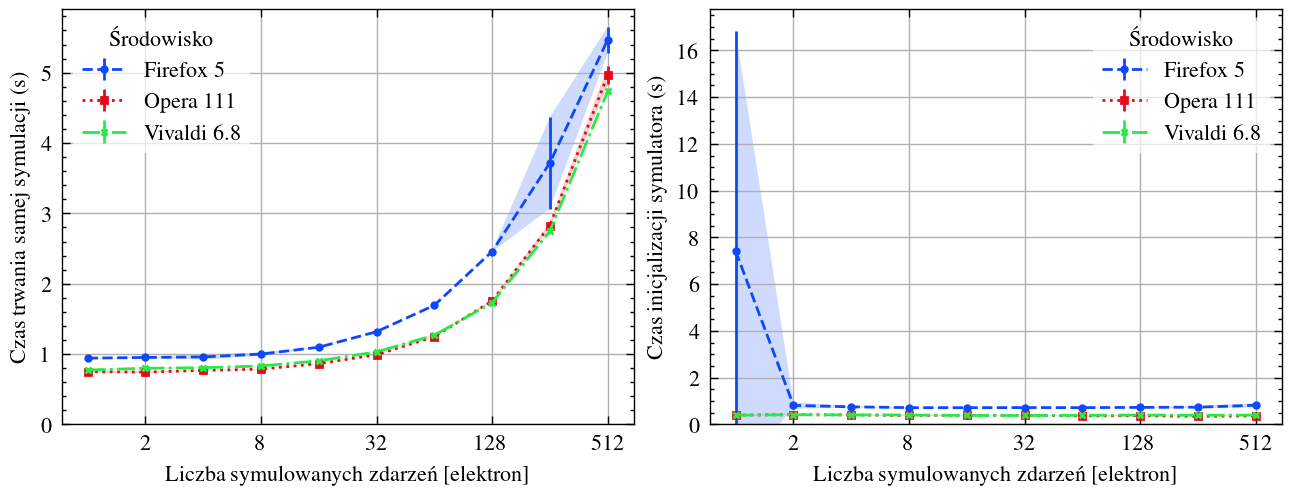

In [46]:
with plt.style.context(['science', 'ieee']):
    fig, ax_list = setup_plt(2)
    x_labels = ['numberOfSimulatedEvents', 'numberOfSimulatedEvents']
    y_labels = ['simulation_end', 'simulation_start']
    criteria_list = [
        dict(dataHandling=["all_raw"], numberOfBins=[256], targetFrames=[0], particleType=['electron']),
        dict(dataHandling=["all_raw"], numberOfBins=[256], targetFrames=[0], particleType=['electron']),
    ]
    label_fn_list = [
        lambda log: log['browser'],
        lambda log: log['browser'],
    ]
    for i in range(2):
        ax = ax_list[i]
        set_prop_cycle(3, ax)
        x_label = x_labels[i]
        y_label = y_labels[i]
        row_criteria = criteria_list[i]
        get_label_fn = label_fn_list[i]
        df = get_time_df(
            [basic_serialized_data], 
            row_criteria,
            x_label, get_label_fn
        )
        # normalize 'simulation_end' by 'simulation_start'
        if(y_label == 'simulation_end'):
            df['simulation_end'] = df['simulation_end'] - df['simulation_start']
        lines, labels = plot_time_with_error_fill_df(ax, df, x_label, y_label)
        ax.set_xlabel('Liczba symulowanych zdarzeń [elektron]')
        if(y_label == 'simulation_end'):
            ax.set_ylabel('Czas trwania samej symulacji (s)')
        else:
            ax.set_ylabel('Czas inicjalizacji symulatora (s)')
        # add legend and map labels into human readable form
        legend = setup_legend(ax, lines, [label.replace('_', ' ') for label in labels], title='Środowisko')
        if(y_label == 'simulation_end'):
            print('A) Porównanie czasu trwania samej symulacji niezależnie od inicjalizacji dla różnych przeglądarek.')
        else:
            print('B) Porównanie czasu inicjalizacji symulatora dla różnych przeglądarek.')
    plt.show()

A) Porównanie czasu trwania samej symulacji niezależnie od inicjalizacji z uruchomieniem lub bez uruchomienia wizualizacji na równoległym procesie.
B) Porównanie czasu inicjalizacji symulatora z uruchomieniem lub bez uruchomienia wizualizacji na równoległym procesie.


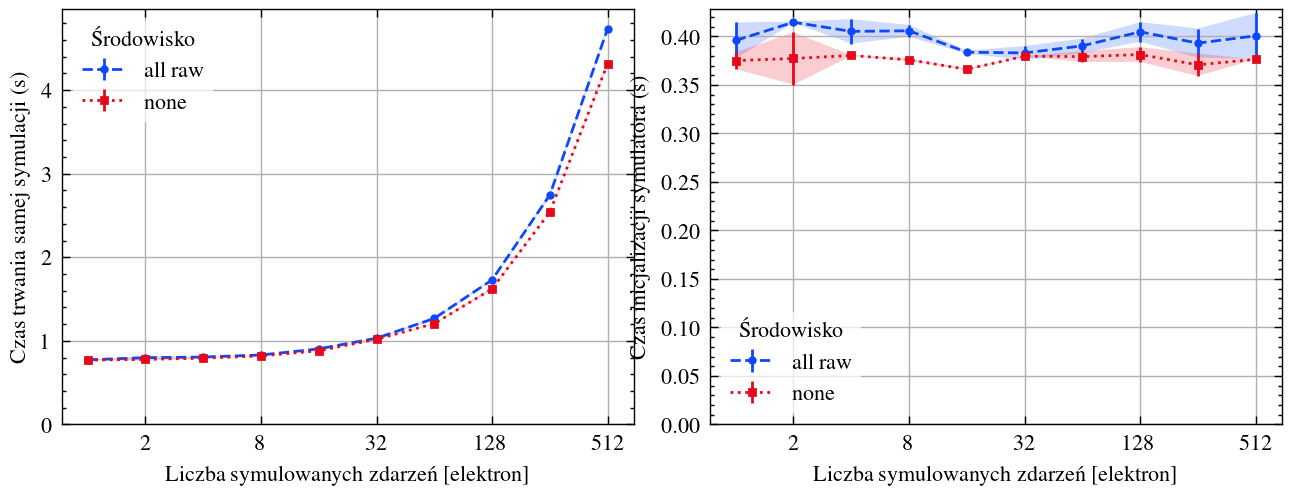

In [47]:
with plt.style.context(['science', 'ieee']):
    fig, ax_list = setup_plt(2)
    x_labels = ['numberOfSimulatedEvents', 'numberOfSimulatedEvents']
    y_labels = ['simulation_end', 'simulation_start']
    criteria_list = [
        dict(dataHandling=["all_raw", 'none'], numberOfBins=[256], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.8']),
        dict(dataHandling=["all_raw", 'none'], numberOfBins=[256], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.8']),
    ]
    label_fn_list = [
        lambda log: log['dataHandling'],
        lambda log: log['dataHandling'],
    ]
    for i in range(2):
        ax = ax_list[i]
        x_label = x_labels[i]
        y_label = y_labels[i]
        row_criteria = criteria_list[i]
        get_label_fn = label_fn_list[i]
        df = get_time_df(
            [basic_serialized_data], 
            row_criteria,
            x_label, get_label_fn
        )
        # normalize 'simulation_end' by 'simulation_start'
        if(y_label == 'simulation_end'):
            df['simulation_end'] = df['simulation_end'] - df['simulation_start']
        lines, labels = plot_time_with_error_fill_df(ax, df, x_label, y_label)
        ax.set_xlabel('Liczba symulowanych zdarzeń [elektron]')
        if(y_label == 'simulation_end'):
            ax.set_ylabel('Czas trwania samej symulacji (s)')
        else:
            ax.set_ylabel('Czas inicjalizacji symulatora (s)')
        # add legend and map labels into human readable form
        legend = setup_legend(ax, lines, [label.replace('_', ' ') for label in labels], title='Środowisko')
        if(y_label == 'simulation_end'):
            print('A) Porównanie czasu trwania samej symulacji niezależnie od inicjalizacji z uruchomieniem lub bez uruchomienia wizualizacji na równoległym procesie.')
        else:
            print('B) Porównanie czasu inicjalizacji symulatora z uruchomieniem lub bez uruchomienia wizualizacji na równoległym procesie.')
    plt.show()

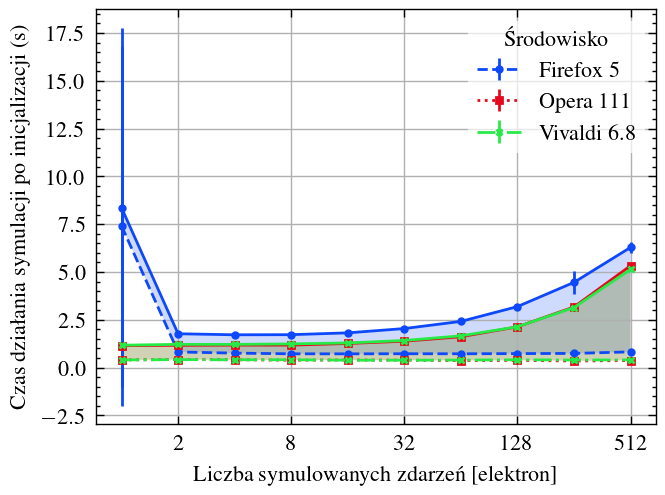

In [53]:
with plt.style.context(['science', 'ieee']):
    fig, [ax] = setup_plt()
    set_prop_cycle(3, ax)
    x_labels = ['numberOfSimulatedEvents', 'numberOfBins']
    row_criteria = [
        dict(dataHandling=["all_raw"], numberOfBins=[256], targetFrames=[0], particleType=['electron']),
        dict(dataHandling=["all_raw"], numberOfSimulatedEvents=[1024], targetFrames=[0], particleType=['electron'])
    ]
    x_label = x_labels[0]
    criteria = row_criteria[0]
    df = get_time_df(
        [all_electrons_serialized_data, basic_serialized_data], 
        criteria,
        x_label, lambda log: log['browser'] # {log['targetFrames']}_{log['numberOfBins']}_{log['particleType']}_{log['dataHandling']}_
    )
    lines, labels = plot_simulation_time_df(ax, df, x_label)
    ax.set_xlabel('Liczba symulowanych zdarzeń [elektron]')
    ax.set_ylabel('Czas działania symulacji po inicjalizacji (s)')
    # add legend and map labels into human readable form
    legend = setup_legend(ax, lines, [label.replace('_', ' ') for label in labels], title='Środowisko')
    
    # annotate_percentage_difference(df, 'simulation_start', ax, (6.3, 0.15), (1, 6.5))
    # annotate_percentage_difference(df, 'simulation_end', ax, (68, 2.6), (12,8.25))
    
    plt.show()

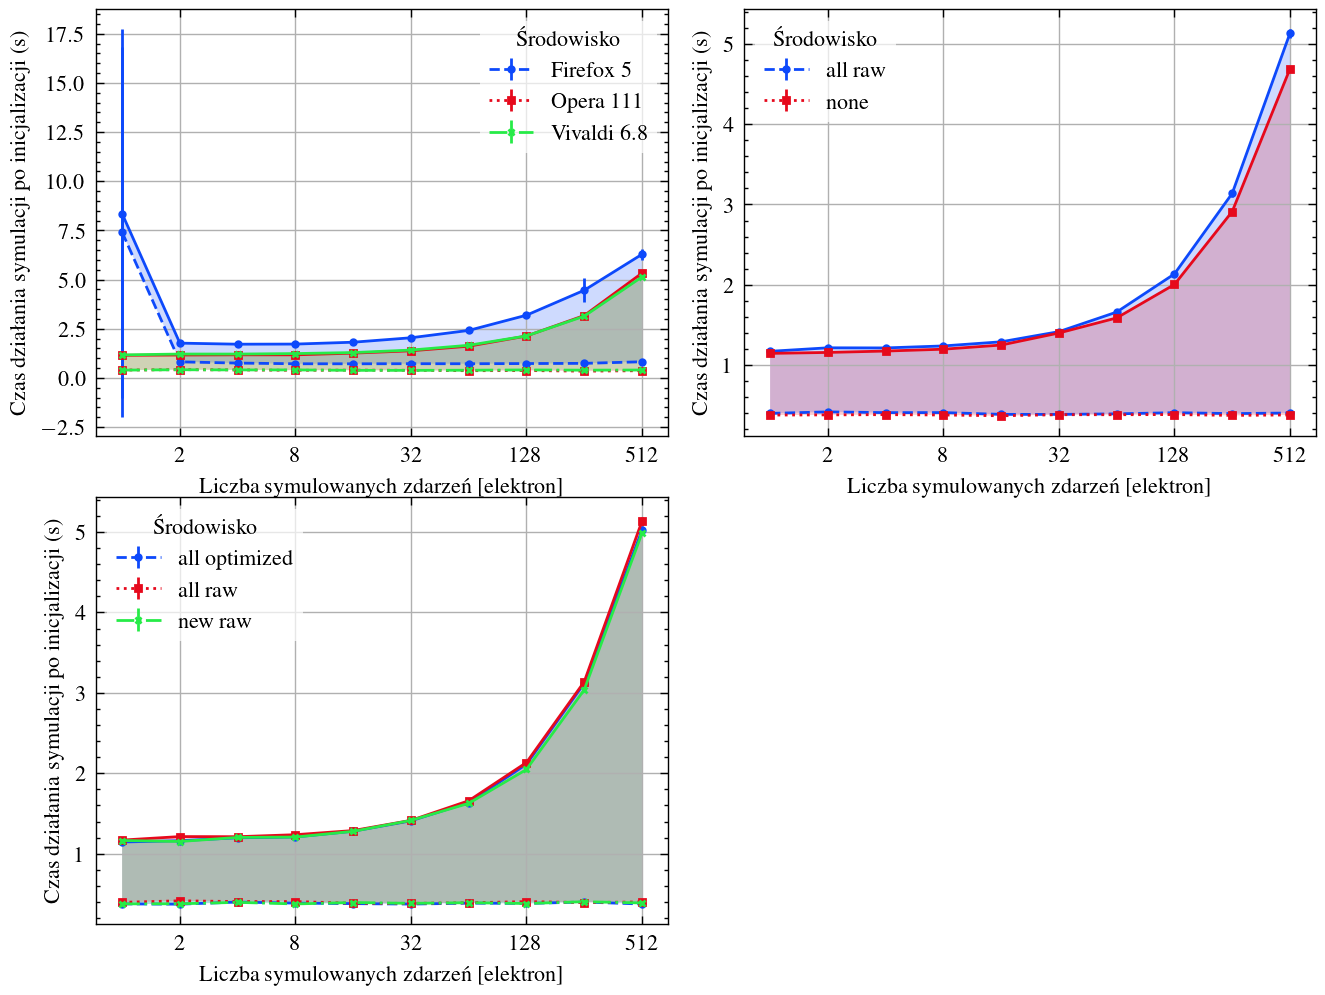

In [54]:
with plt.style.context(['science', 'ieee']):
    fig, axes_list = setup_plt(2,2)
    x_labels = ['numberOfSimulatedEvents', 'numberOfSimulatedEvents', 'numberOfSimulatedEvents']
    row_criteria = [
        dict(dataHandling=["all_raw"], numberOfBins=[256], targetFrames=[0], particleType=['electron']),
        dict(dataHandling=["all_raw",'none'], numberOfBins=[256], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.8']),
        dict(dataHandling=["all_raw",'new_raw', 'all_optimized'], numberOfBins=[256], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.8'])
    ]
    get_label_fns = [
        lambda log: log['browser'],
        lambda log: log['dataHandling'],
        lambda log: log['dataHandling']
    ]
    for i in range(3):
        ax = axes_list[i]
        if i == 1:
            set_prop_cycle(2, ax)
        else:
            set_prop_cycle(3, ax)
        x_label = x_labels[i]
        criteria = row_criteria[i]
        get_label_fn = get_label_fns[i]
        df = get_time_df(
            [basic_serialized_data], 
            criteria,
            x_label, get_label_fn # {log['targetFrames']}_{log['numberOfBins']}_{log['particleType']}_{log['dataHandling']}_
        )
        lines, labels = plot_simulation_time_df(ax, df, x_label)
        ax.set_xlabel('Liczba symulowanych zdarzeń [elektron]')
        ax.set_ylabel('Czas działania symulacji po inicjalizacji (s)')
        # add legend and map labels into human readable form
        legend = setup_legend(ax, lines, [label.replace('_', ' ') for label in labels], title='Środowisko')
    
        # annotate_percentage_difference(df, 'simulation_start', ax, (6.3, 0.15), (1, 6.5))
        # annotate_percentage_difference(df, 'simulation_end', ax, (68, 2.6), (12,8.25))
    axes_list[3].remove()
    plt.show()

In [55]:
if False:
    with plt.style.context(['science', 'ieee']):
        plt.close('all')

        human_readable_label = lambda label: label.replace('testEnd', 'All').replace('basic_raw', 'Basic').replace('electron', 'Electron').replace('proton', 'Proton').replace('serial', 'Serial').replace('parallel', 'Parallel').replace('gpu', 'GPU').replace('cpu', 'CPU')
        fig, ax = plt.subplots()
        fig.dpi = 200
        x_label = 'numberOfSimulatedEvents'
        df = get_time_df(
            [all_electrons_serialized_data, basic_serialized_data], 
            dict(dataHandling=["all_raw"], numberOfBins=[256], targetFrames=[0], particleType=['electron']),
            x_label, lambda log: log['browser'] # {log['targetFrames']}_{log['numberOfBins']}_{log['particleType']}_{log['dataHandling']}_
        )
        lines, labels = plot_simulation_time_df(fig, ax, df, x_label)
        ax.set_xlabel('Liczba symulowanych zdarzeń [elektron]')
        ax.set_ylabel('Czas (s)')
        # add legend and map labels into human readable form
        legend = ax.legend(lines, [label.replace('_', ' ') for label in labels], title='Środowisko', frameon=True)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(.7)
        legend.get_frame().set_linewidth(0)
        
        annotate_percentage_difference(df, 'simulation_start', ax, (6.3, 0.15), (1, 6.5))
        annotate_percentage_difference(df, 'simulation_end', ax, (68, 2.6), (12,8.25))
        
        plt.show()
    def plot_total_time(fig: Figure, 
            ax: Axes, 
            data_list: List[Dict[str,List[Result]]], 
            series_criteria: Dict[str, List[any]], 
            x_label, 
            label_fn: Callable[[Result], str]=get_full_log_key,
            sort_labels: Callable[[List[str]], List[str]]=lambda x: sorted(x)
        ) -> List[Tuple[str, Line2D]]:
        # use custom cycler for line styles and don't use '-'
        custom_linestyles=[(0,(4,2)),(0,(1,1)),'-.', (0,(5,2,1,1,1,2)), ]
        rows = []
        lines = []
        # merge all data into one dictionary for easier processing
        # if key is the same, append the data
        total_data: Dict[str,List[Result]] = {}
        [total_data.update(data) for data in data_list]
        for logs in total_data.values():
            if not all(logs[0][k] in v for k, v in series_criteria.items()):
                continue
            label = label_fn(logs[0])
            x = int(logs[0][x_label])
            for log in logs:
                _, times = zip(*log["timeStamps"])
                rows.append({
                    "label": label,
                    "x": x,
                    "y": times[-1] - times[0],
                })
        if len(rows) == 0:
            return []
        df = pd.DataFrame(rows)
        df_mean = df.groupby(["label", "x"]).mean().reset_index()
        df_std = df.groupby(["label", "x"]).std().reset_index()
        
        sorted_labels = sort_labels(df_mean.label.unique())
        
        # Create a categorical type with the order defined by sorted_labels
        df_mean['label'] = pd.Categorical(df_mean['label'], categories=sorted_labels, ordered=True)
        df_std['label'] = pd.Categorical(df_std['label'], categories=sorted_labels, ordered=True)
        
        # Sort the DataFrame based on the 'label' column
        df_mean.sort_values('label', inplace=True)
        df_std.sort_values('label', inplace=True)
        
        # Plotting
        for label, group in df_mean.groupby('label'):
            group = group.sort_values('x')
            [line] = ax.plot(group['x'], group['y'], label=label, linestyle=custom_linestyles[sorted_labels.index(label) % len(custom_linestyles)])
            ax.fill_between(group['x'], group['y'] - df_std.loc[df_std['label'] == label, 'y'].values, group['y'] + df_std.loc[df_std['label'] == label, 'y'].values, alpha=0.2)
            lines.append(line)
        
        return list(zip(sorted_labels, lines))
    def generate_plot_with_total_time(series_criteria, x_label, x_key, y_label, plot_args, 
            label_fn: Callable[[Result], str]=get_full_log_key,
            sort_fn: Callable[[List[str]], List[str]]=lambda x: sorted(x)):
        with plt.style.context(['science', 'ieee', 'high-vis']):
            fig, ax = plt.subplots(figsize=(4, 3))
            fig.dpi = 300
            
            # plot the total time taken for each log
            plots = plot_total_time(fig, ax, plot_args, series_criteria, x_key, label_fn, sort_fn)
            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)
            print('Tytuł: Porównanie czasów trwania symulacji oraz wizualizacji dla różnych środowisk przeglądarkowych')
            ax.set_xscale("log", base=2)
            ax.set_yscale("log", base=2)
            ax.grid()
            labels, lines = zip(*plots)
            legend = ax.legend([(mpatches.Patch(color=line.get_color(), linewidth=0, alpha=0.2), line) for line in lines], labels, frameon=True)
            legend.get_frame().set_facecolor('white')
            legend.get_frame().set_alpha(.5)
            legend.get_frame().set_linewidth(0)
            plt.show()

    def generate_two_plots_with_total_time(series_criteria_a, series_criteria_b, x_label_a, x_label_b, x_key, y_label, plot_args_a, plot_args_b, 
            label_fn: Callable[[Result], str]=get_full_log_key, 
            sort_fn: Callable[[List[str]], List[str]]=lambda x: sorted(x)):
        with plt.style.context(['science', 'ieee', 'high-vis']):
            fig, axs = plt.subplots(1, 2, figsize=(8, 3))
            fig.dpi = 200
            for i, (ax, plot_args, series_criteria, x_label) in enumerate(zip(axs, [plot_args_a, plot_args_b], [series_criteria_a, series_criteria_b], [x_label_a, x_label_b])):
                # plot the total time taken for each log
                print(plot_args, series_criteria,x_label)
                plots = plot_total_time(fig, ax, plot_args, series_criteria, x_key, label_fn, sort_fn)
                if len(plots) == 0: 
                    fig.delaxes(ax)
                    continue
                ax.set_xlabel(x_label)
                ax.set_ylabel(y_label)
                ax.set_xscale("log", base=2)
                ax.set_yscale("log", base=2)
                ax.grid()
                labels, lines = zip(*plots)
                legend = ax.legend([(mpatches.Patch(color=line.get_color(), linewidth=0, alpha=0.2), line) for line in lines], labels, frameon=True)
                legend.get_frame().set_facecolor('white')
                legend.get_frame().set_alpha(.5)
                legend.get_frame().set_linewidth(0)
            plt.show()
    label_fn = lambda log: f'{    "Wizualizacja" if log["dataHandling"] == "all_raw" else "Symulacja"} {"elektronów" if log["particleType"] == "electron" else "protonów"} dla {log["browser"]}'
    sort_fn = lambda x: sorted(x, key=lambda x: x.split(' ')[-1]) 
    browser_label_fn = lambda log: f'{"Wizualizacja" if log["dataHandling"] == "all_raw" else "Symulacja"} w środowisku {log["browser"]}'
    generate_two_plots_with_total_time(
        dict(dataHandling=["all_raw", "none"], numberOfBins=[128], targetFrames=[0], particleType=['electron']),
        dict(dataHandling=["all_raw", "none"], numberOfBins=[128], targetFrames=[0], particleType=['proton']),
        "Liczba zasymulowanych zdarzeń [elektron]", "Liczba zasymulowanych zdarzeń [proton]", "numberOfSimulatedEvents", "Czas trwania [s]",
        [all_electrons_serialized_data, basic_serialized_data],
        [all_protons_serialized_data, basic_serialized_data],
        browser_label_fn, sort_fn
    )
    frame_label_fn = lambda log: f'Docelowy FPS {log["targetFrames"]}'
    fps_sort_fn = lambda x: sorted(x, key=lambda x: float(x.split(' ')[-1]))
    generate_two_plots_with_total_time(
        dict(dataHandling=["all_raw"], numberOfBins=[256], particleType=['electron'], browser=['Vivaldi_6.8']),
        dict(dataHandling=["all_raw"], numberOfBins=[256], particleType=['proton'], browser=['Vivaldi_6.8']),
        "Liczba zasymulowanych zdarzeń [elektron]", "Liczba zasymulowanych zdarzeń [proton]", "numberOfSimulatedEvents", "Czas trwania [s]",
        [all_electrons_serialized_data, basic_serialized_data],
        [all_electrons_serialized_data, basic_serialized_data],
        frame_label_fn, fps_sort_fn
    )
    generate_plot_with_total_time(
        series_criteria=dict(dataHandling=['all_raw', 'none'], numberOfBins=[256], targetFrames=[0]),
        x_label='Ilość symulowanych zdarzeń [event]',
        x_key='numberOfSimulatedEvents',
        y_label='Czas trwania [s]',
        plot_args=[all_electrons_serialized_data, all_protons_serialized_data, basic_serialized_data],
        label_fn=label_fn, 
        sort_fn=sort_fn
    )
    generate_plot_with_total_time(
        series_criteria=dict(dataHandling=['all_raw', 'none'], numberOfSimulatedEvents=[512], targetFrames=[0], particleType=['electron']),
        x_label="Ilość podziałów siatki detektora [bins]",
        x_key='numberOfBins',
        y_label='Czas trwania [s]',
        plot_args=[all_electrons_serialized_data, basic_serialized_data],
        label_fn = label_fn,
        sort_fn = sort_fn
    )
    def stacked_time_separated_by_phase(fig: Figure, 
            ax: Axes,
            data_list: List[Dict[str,Result]], 
            series_criteria: Dict[str, List[any]], 
            x_label, 
            label_fn: Callable[[Result], str]=get_full_log_key,
            sort_labels: Callable[[str], List[str]]=lambda x: sorted(x)
        ):
        # Initialize a list to collect DataFrame rows
        rows = []

        # Populate the list with row data
        for data in data_list:
            for _, logs in data.items():
                if not all(logs[0][k] in v for k, v in series_criteria.items()):
                    continue
                label = label_fn(log[0])
                for log in logs:
                    wait_time = log["timeStamps"][-1][1] - log["timeStamps"][0][1] - log.get("renderTime", 0) - log.get("handleTime", 0) - log.get("optimizeTime", 0)
                    rows.append({
                        "label": label,
                        "oczekiwanie": wait_time,
                        "rendering": log.get("renderTime", 0),
                        "przetwarzanie danych": log.get("handleTime", 0),
                        "optymalizacja danych": log.get("optimizeTime", 0)
                    })

        # Convert the list of rows into a DataFrame
        df = pd.DataFrame(rows)

        # Group by label and calculate mean for each phase
        df_mean = df.groupby('label').mean()

        # Sort the labels if a custom sorting function is provided
        sorted_labels = sort_labels(df_mean.index)
        df_mean = df_mean.loc[sorted_labels]

        # Plotting
        bars = df_mean[['oczekiwanie', 'rendering', 'przetwarzanie danych', 'optymalizacja danych']].plot(kind='bar', stacked=True, ax=ax)
        ax.set_xlabel(x_label)
        ax.set_ylabel('Time')
        
        # return zip(sorted_labels, bars)
    stack_label_fn = lambda log: f'{"Surowe" if log["dataHandling"] == "all_raw" else "Zoptymalizowane"} dane trajektorii {"elektronów" if log["particleType"] == "electron" else "protonów"}'
    with plt.style.context(['science', 'ieee', 'high-vis']):
            fig, ax = plt.subplots(figsize=(4, 3))
            fig.dpi = 300
            
            # plot the total time taken for each log
            stacked_time_separated_by_phase(fig, ax, 
                [all_electrons_serialized_data, all_protons_serialized_data, basic_serialized_data], 
                dict(dataHandling=['all_raw', 'all_optimized'], numberOfBins=[256], numberOfSimulatedEvents=[512], targetFrames=[0], particleType=['proton'], browser=['Vivaldi_6.8']), 
                "numberOfSimulatedEvents", stack_label_fn, sort_fn)
            ax.set_xlabel("Konfiguracja wizualizacji")
            ax.set_ylabel("Czas trwania [s]")
            print('Tytuł: Porównanie czasów trwania etapów wizualizacji dla różnych konfiguracji wizualizacji')
            ax.grid(axis='y')
            # labels, lines = zip(*plots)
            # print(lines, labels)
            # legend = ax.legend([(mpatches.Patch(color=line[0].get_color(), linewidth=0, alpha=0.2), line[0]) for line in lines], labels, frameon=True)
            # legend.get_frame().set_facecolor('white')
            # legend.get_frame().set_alpha(.5)
            # legend.get_frame().set_linewidth(0)
            plt.show()